# CNN - Convolutional Neural Network Tutorial - Using Pytorch
> This is a tutorial of image classification using CNN (convolutional dataset)

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/CNN.png

![](my_icons/CNN.png)

In [107]:
import torch
import os
import torchvision
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.datasets.utils import download_url
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import tarfile
import yaml
import numpy as np

In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 5

In [109]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transforms.ToTensor())

random_seed = 42
torch.manual_seed(random_seed)
train_dataset,val_dataset = random_split(train_dataset,[45000,5000])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size*2,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

#Classes of labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [110]:
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

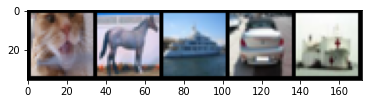

In [111]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

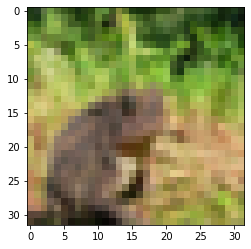

In [112]:
plt.imshow(train_dataset[4][0].permute(1, 2, 0) );

torch.Size([5, 3, 32, 32])
tensor([1, 5, 2, 0, 3])


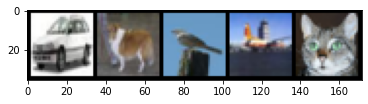

In [113]:
for batch,label in train_loader:
    print(batch.shape)
    print(label)
    plt.imshow(torchvision.utils.make_grid(batch).permute(1,2,0))
    break

In [114]:
# Creating the dataloader
train_loader = DataLoader(train_dataset,batch_size=8,shuffle = True)
val_loader = DataLoader(val_dataset,batch_size=8,shuffle = True)

# Steps of a CNN
> Convolutions - The process involves the kernel performing element wise multiplication with the input it is currently on and the kernel slides

> Max pooling - Decreases the dimension of the output tensor

In [115]:
layer1 = nn.Conv2d(3,62,5)
pooling = nn.MaxPool2d(2,2)
layer2 = nn.Conv2d(62,128,5)
layer3 = nn.Conv2d(128,128,5)

In [116]:
for batch,label in train_loader:
    print(batch.shape, label.shape)
    dta = layer1(batch)
    print(dta.shape)
    dta = pooling(dta)
    print(dta.shape)
    dta = layer2(dta)
    print(dta.shape)
    dta = pooling(dta)
    print(dta.shape)
    break

torch.Size([8, 3, 32, 32]) torch.Size([8])
torch.Size([8, 62, 28, 28])
torch.Size([8, 62, 14, 14])
torch.Size([8, 128, 10, 10])
torch.Size([8, 128, 5, 5])


In [117]:
#Model
class convnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,62,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(62,128,5)
        self.linear1 = nn.Linear(128*5*5, 140)
        self.linear2 = nn.Linear(140,80)
        self.linear3 = nn.Linear(80,10)
         
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1,128*5*5)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return x

In [118]:
def metric_acc(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def results_epoch(out_lst):
    val_loss_epoch = torch.stack([dct['val_loss'] for dct in out_lst]).mean()
    val_acc_epoch = torch.stack([dct['val_acc'] for dct in out_lst]).mean()
    return {'val_loss': val_loss_epoch.item(), 'val_acc': val_acc_epoch.item()}

def final_output(dct,epoch):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, dct['val_loss'], dct['val_acc']))
   
def validation(batch_val,model):
    img_val,label_val = batch_val
    pred_val = model(img_val)
    # loss is computed
    loss_val = F.cross_entropy(pred_val,label_val)
    # Accuracy is computed
    acc_val = metric_acc(pred_val,label_val)
    return {'val_loss': loss_val, 'val_acc': acc_val}
    
def check_scores(val_loader,model):
    out_lst = [validation(batch_val,model) for batch_val in val_loader]
    return results_epoch(out_lst)

def fit(epochs,learning_rate,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate , momentum=0.9)
    out_lst = []
    for epoch in range(epochs):
        
        # Training step on the training dataloader
        for batch in train_loader:
            #extract batch of images and label
            img,label = batch
            #calculate prediction using the MNISTMODEL class initialized above
            pred = model(img)
            #Since this is a multi-label image classification model- the loss function is cross entropy
            loss = F.cross_entropy(pred,label)
            # In this step we calculate the gradient of the loss function with respect to the parameters or 784 pixels in this case
            loss.backward()
            # In this step we update the weights
            optimizer.step()
            # We make the gradient zero again so that now the gradients are not calculated untill the training is not done
            optimizer.zero_grad()
         
        # Validation on the validation dataloader   
        output = check_scores(val_loader,model)
        out_lst.append(output)
        final_output(output,epoch)
        
    return out_lst

In [119]:
model = convnet()

In [122]:
starting =  check_scores(val_loader,model)
print(starting)
out_lst = fit(14,learning_rate=0.005,model= model,train_loader = train_loader,val_loader = val_loader)

{'val_loss': 1.5662833452224731, 'val_acc': 0.4575999975204468}
Epoch [0], val_loss: 1.1406, val_acc: 0.6052
Epoch [1], val_loss: 1.0728, val_acc: 0.6336
Epoch [2], val_loss: 1.1686, val_acc: 0.6010
Epoch [3], val_loss: 1.1197, val_acc: 0.6216
Epoch [4], val_loss: 1.1326, val_acc: 0.6318
Epoch [5], val_loss: 1.0791, val_acc: 0.6434
Epoch [6], val_loss: 1.1464, val_acc: 0.6598
Epoch [7], val_loss: 1.1794, val_acc: 0.6530
Epoch [8], val_loss: 1.1947, val_acc: 0.6570
Epoch [9], val_loss: 1.2358, val_acc: 0.6566
Epoch [10], val_loss: 1.3344, val_acc: 0.6558
Epoch [11], val_loss: 1.3603, val_acc: 0.6532
Epoch [12], val_loss: 1.4222, val_acc: 0.6500
Epoch [13], val_loss: 1.4345, val_acc: 0.6526


# Model performance on the test set